# Consensus - based Parallel SVM

In [1]:
import numpy as np
import csv
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
import cvxpy as cp

from utils import *

### Breast Cancer dataset

In [2]:
X_train, X_test, y_train, y_test = load_breast_test_train_dataset()

### Loan Clients dataset

In [2]:
X_train, X_test, y_train, y_test = load_Loan_test_train_dataset()

In [11]:
sum(y_train == 1)/len(y_train)
sum(y_test == 1)/len(y_test)

array([0.3624054])

In [4]:
X_test.shape

(9401, 50)

### Normalize data

In [3]:
normalizer_ = Normalizer()
normalizer_.fit(X_train)

X_train = normalizer_.transform(X_train)
X_test = normalizer_.transform(X_test)

In [4]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


# Optimization --  Parallel Consensus-based SVM

## **Divide data into blocks - splitting across data points**

In [4]:
def get_chunks(data, n):
    return [data[i:i + n] for i in range(0, len(data), n)]

In [5]:
def generate_A_mat(X, y):
    
    # Add ONE at the end of all x-data vectors
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
    
    # -1 * y_vector
    minus_y = np.multiply(-1, y).reshape(-1, 1)
    
    # Componentiwise multiplication
    A = np.multiply(minus_y, X)
    return A

### ADMM

In [6]:
class Node():
    
    def __init__(self, A_chunk, x, rho):
        self.A = A_chunk
        self.x = x
        self.rho = rho
    
    def compute_x_i(self, u_i, z):
        self.u = u_i.reshape(-1, 1)
        z = z.reshape(-1, 1)
        
        m, n = self.A.shape
        x = cp.Variable((n, 1))
        rho = cp.Parameter(nonneg=True)
        rho.value = self.rho
        
        loss = cp.sum(cp.pos(1 + self.A * x))
        reg = cp.sum_squares(x - z + self.u)
        prob = cp.Problem(cp.Minimize(loss + rho/2*reg))
        prob.solve(verbose=False, solver='ECOS')#solver='OSQP'
        self.x = x.value
        
        del prob
        
    def compute_u_i(self, z):
        self.u = self.u.reshape(-1,1) + self.x - z

In [48]:
class FusionCenter():
    
    def __init__(self, N, rho, lamb, nodes):
        self.N = N
        self.rho = rho
        self.lamb = lamb
        self.nodes = nodes #to observe all Node instances
        
    def _average_x_u(self):
        x = np.array(self.x_list) 
        u = np.array(self.u_list)
        
        self.x_bar = np.average(x, axis=0).reshape(-1,1)
        self.u_bar = np.average(u, axis=0).reshape(-1,1)
        
    def collect_x_u(self):
        self.x_list = []
        self.u_list = []
        
        for node in self.nodes:
            self.x_list.append(node.x)
            self.u_list.append(node.u)
        
        print([x_ch[0] for x_ch in self.x_list])
        self._average_x_u()
    
    def compute_z(self):
        const_part = self.N * self.rho / (2*self.lamb + self.N*self.rho)
        self.z = const_part * (self.x_bar + self.u_bar)
#         print(self.z[0])
    
    def check_consensus(self, error_tol):
        "checking disagreement"
        err_tot = 0
        for x in self.x_list:
            err = np.linalg.norm(x - self.x_bar, ord=2)**2
            err_tot += err
        if err_tot/self.N < error_tol:
            return True
        else:
            return False
        
#         for x in self.x_list:
#             diff = x - self.x_bar
# #             diff = x - self.z
    
#             if (abs(diff) > error_tol).any():
#                 return False
#             else:
#                 return True
            
    def calculate_disagr(self):
        err_tot = 0
        for x in self.x_list:
            err = np.linalg.norm(x - self.x_bar, ord=2)**2
            err_tot += err
        return err_tot/self.N
        

In [41]:
def traintest_predict(x):
    y_pred_tr = np.sign(A_train.dot(x))
    y_pred_te = np.sign(A_test.dot(x))
    
    return y_pred_tr, y_pred_te


def get_accuracies(y_pred_tr, y_pred_te):
    train_acc = accuracy_score(y_train, y_pred_tr)
    test_acc = accuracy_score(y_test, y_pred_te)
    
    return train_acc, test_acc

### def __main__:

In [42]:
# Preprocess data

NODES = 4

A_test = generate_A_mat(X_test, y_test)
A_train = generate_A_mat(X_train, y_train)
A_chunks = get_chunks(A_train, int(np.ceil(X_train.shape[0]/NODES)))

for ch in A_chunks:
    print(ch.shape)

(5484, 51)
(5484, 51)
(5484, 51)
(5482, 51)


In [61]:
# Fixed parameters:

RHO = 450#1e4 #450
LAMBD = 10
N = len(A_chunks)
E_TOL = 0.00005

####  First iteration:

In [62]:
N, m = X_train.shape
x_init = np.zeros(m+1)
z_init = np.zeros(m+1)
u_init = np.zeros(m+1)

In [63]:
node1 = Node(A_chunk = A_chunks[0], x=x_init, rho = RHO)
node2 = Node(A_chunk = A_chunks[1], x=x_init, rho = RHO)
node3 = Node(A_chunk = A_chunks[2], x=x_init, rho = RHO)
node4 = Node(A_chunk = A_chunks[3], x=x_init, rho = RHO)

node1.compute_x_i(u_i = u_init, z = z_init)
node2.compute_x_i(u_i = u_init, z = z_init)
node3.compute_x_i(u_i = u_init, z = z_init)
node4.compute_x_i(u_i = u_init, z = z_init)

In [64]:
history_disagr = []

FC = FusionCenter(N=NODES, rho=RHO, lamb=LAMBD,
                 nodes = [node1, node2, node3, node4])


FC.collect_x_u()

disagr = FC.calculate_disagr()
history_disagr.append(disagr)

consensus = FC.check_consensus(error_tol=E_TOL)

FC.compute_z()


########### SAVE SOME INTERMEDIATE RESULTS
history_acc = []
y_pred_tr, y_pred_te = traintest_predict(x = FC.x_bar)
train_acc, test_acc = get_accuracies(y_pred_tr, y_pred_te)
history_acc.append((train_acc, test_acc))



[array([-0.07554833]), array([-0.08037712]), array([-0.08508378]), array([-0.07092985])]


In [65]:
history_disagr

[0.00021178169002273488]

#### More iterations:

In [66]:
counter = 1 # Check the number of iterations
while not consensus:
    counter += 1
#     if counter > 5: break
    print(counter, end="\n")
    
    node1.compute_u_i(z = FC.z)
    node2.compute_u_i(z = FC.z)
    node3.compute_u_i(z = FC.z)
    node4.compute_u_i(z = FC.z)

    node1.compute_x_i(u_i = FC.u_list[0], z = FC.z)
    node2.compute_x_i(u_i = FC.u_list[1], z = FC.z)
    node3.compute_x_i(u_i = FC.u_list[2], z = FC.z)
    node4.compute_x_i(u_i = FC.u_list[3], z = FC.z)
    
    FC.collect_x_u()
    disagr = FC.calculate_disagr()
    history_disagr.append(disagr)
    consensus = FC.check_consensus(error_tol=E_TOL)
    FC.compute_z()
    
    
    ########### SAVE SOME INTERMEDIATE RESULTS
    y_pred_tr, y_pred_te = traintest_predict(x = FC.x_bar)
    train_acc, test_acc = get_accuracies(y_pred_tr, y_pred_te)
    history_acc.append((train_acc, test_acc))
    
#     print("train\n", confusion_matrix(y_train, y_pred_tr))
#     print("\ntest\n", confusion_matrix(y_test, y_pred_te))

2
[array([-0.06756953]), array([-0.07013045]), array([-0.07595215]), array([-0.06077555])]
3
[array([-0.05319314]), array([-0.05510243]), array([-0.06081648]), array([-0.04600303])]
4
[array([-0.03788156]), array([-0.0405958]), array([-0.04530529]), array([-0.03203457])]
5
[array([-0.02471793]), array([-0.02742487]), array([-0.03188361]), array([-0.01931189])]
6
[array([-0.01333883]), array([-0.01493697]), array([-0.02009081]), array([-0.00812566])]
7
[array([-0.00354157]), array([-0.0049225]), array([-0.00976723]), array([0.00175822])]
8
[array([0.00512327]), array([0.00332297]), array([-0.00063658]), array([0.0103795])]
9
[array([0.01192443]), array([0.01070816]), array([0.00704114]), array([0.01721958])]
10
[array([0.01792232]), array([0.01703656]), array([0.01352846]), array([0.023409])]
11
[array([0.02372219]), array([0.02271686]), array([0.01972404]), array([0.02820551])]
12
[array([0.02821056]), array([0.02742532]), array([0.0240894]), array([0.03274535])]
13
[array([0.03146786]

[array([0.04592119]), array([0.0456068]), array([0.04283726]), array([0.05114194])]
97
[array([0.04603127]), array([0.04573126]), array([0.04295282]), array([0.05125132])]
98
[array([0.04614641]), array([0.0458505]), array([0.04306184]), array([0.05137127])]
99
[array([0.04625767]), array([0.04596476]), array([0.04316097]), array([0.05149476])]
100
[array([0.04636051]), array([0.04607313]), array([0.04326133]), array([0.05161306])]
101
[array([0.04646093]), array([0.04617806]), array([0.043363]), array([0.05172237])]
102
[array([0.04656549]), array([0.04628528]), array([0.04346266]), array([0.05181949])]
103
[array([0.04667632]), array([0.04639146]), array([0.04355417]), array([0.05191488])]
104
[array([0.04678811]), array([0.04650652]), array([0.04364629]), array([0.05203112])]
105
[array([0.046903]), array([0.04661086]), array([0.04374272]), array([0.05215456])]
106
[array([0.04701525]), array([0.04671143]), array([0.04384224]), array([0.05227063])]
107
[array([0.04711196]), array([0

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [67]:
print("No. Iterations = ", counter)

No. Iterations =  109


**PREDICTIONS and VALIDATION**

In [68]:
# y_pred_tr, y_pred_te = traintest_predict(x = FC.x_bar)
y_pred_tr = np.sign(A_train.dot(FC.z))
y_pred_te = np.sign(A_test.dot(FC.z))


In [69]:
print("train\n", confusion_matrix(y_train, y_pred_tr))
print("\ntest\n", confusion_matrix(y_test, y_pred_te))

train_acc, test_acc = get_accuracies(y_pred_tr, y_pred_te)
print("\nACC: train = {:f}, test {:f}".format(train_acc, test_acc))

train
 [[13985     0]
 [    0  7949]]

test
 [[6015    0]
 [   0 3386]]

ACC: train = 1.000000, test 1.000000


In [30]:
# FC.x_bar

In [67]:
# FC.x_bar

PLOTS

In [68]:
# Accuracy vs. Number of iterations

In [85]:
plt.plot(range(19), np.ones(19), 'g--', label="Centralised")
plt.plot(range(19), [acc[1] for acc in history_acc[1:20]], label="Consensus (Test ACC)")
plt.ylim(0,1.06)
plt.xlim(0, 10)
plt.xticks(range(10))
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Consensus Optimization", fontsize=20)
plt.savefig("Consensus_Accuracy1.jpg")

1.0

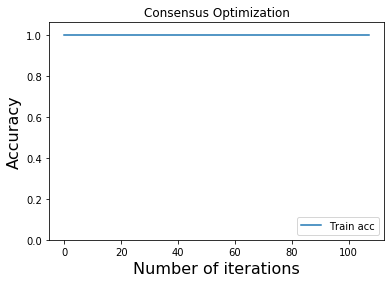

In [71]:
plt.plot(range(counter-1), [acc[0] for acc in history_acc], label="Train acc")
# plt.plot(range(counter-1), [acc[1] for acc in history_acc], label="Test acc")
plt.ylim(0,1.06)
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Consensus Optimization")
plt.savefig("Consensus_Accuracy.jpg")

In [28]:
# Disagreement vs. number of iterations

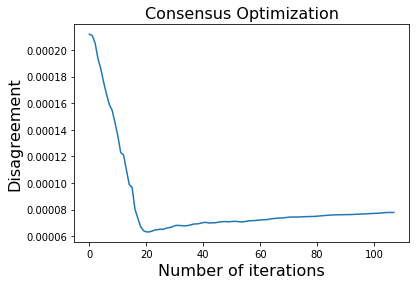

In [73]:
plt.plot(range(counter-1), [dis for dis in history_disagr], label="Disagreement")
plt.title("Consensus Optimization", fontsize=16)
plt.xlabel("Number of iterations", fontsize=16)
plt.ylabel("Disagreement", fontsize=16)
plt.savefig("Consensus_Dis.jpg")

In [88]:
history_disagr

[0.0007360655685318018,
 0.0009125196997430119,
 0.0009922761909713007,
 0.0010382587211182873,
 0.0010491677340656025,
 0.001063376487831978,
 0.0010684453859001505,
 0.001071483753829604,
 0.0010773664581946076,
 0.0010797890799217232,
 0.0010806814632551356,
 0.001081022454963531,
 0.0010814960476317186,
 0.001081728099731574,
 0.0010818299010623398,
 0.0010818834572850105,
 0.001081904719735817,
 0.001081918409006144,
 0.0010819325598782255,
 0.001081936973989447,
 0.0010819397403461278,
 0.0010819413642585466,
 0.0010819422947568019,
 0.001081942820397812,
 0.0010819431129485172,
 0.0010819432726291939,
 0.0010819433575151721,
 0.0010819434007096798,
 0.0010819434213046168,
 0.0010819434297156358,
 0.001081943432179438,
 0.0010819434316239255,
 0.0010819434300294909,
 0.0010819434280689975,
 0.0010819434263203106,
 0.0010819434247586353,
 0.001081943423688201,
 0.0010819434226439291,
 0.0010819434218974407]

## Centralised version

In [11]:
m, n = X_train.shape

x = cp.Variable((n+1, 1))
lambd = cp.Parameter(nonneg=True)
loss = cp.sum(cp.pos(1 + A_train*x))
reg = cp.sum_squares(x)
prob = cp.Problem(cp.Minimize(loss + lambd*reg))

lambd.value = 10

prob.solve(verbose=True, solver='ECOS')


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.425e+03  +7.020e+04  +9e+05  8e-01  2e+01  1e+00  2e+01    ---    ---    2  1  - |  -  - 
 1  +9.588e+03  +6.882e+04  +9e+05  8e-01  2e+01  2e+00  2e+01  0.0270  9e-01   1  1  1 |  0  0
 2  +1.111e+04  +6.687e+04  +8e+05  8e-01  8e+00  8e+00  2e+01  0.1421  8e-01   2  1  2 |  0  0
 3  +1.470e+04  +4.346e+04  +7e+05  4e-01  3e+00  3e+01  2e+01  0.3319  5e-01   3  2  2 |  0  0
 4  +1.485e+04  +4.169e+04  +7e+05  4e-01  3e+00  3e+01  2e+01  0.0505  6e-01   3  2  2 |  0  0
 5  +1.498e+04  +4.120e+04  +7e+05  4e-01  3e+00  3e+01  2e+01  0.0572  9e-01   2  2  2 |  0  0
 6  +1.585e+04  +2.102e+04  +3e+05  7e-02  3e-01  3e+01  6e+00  0.7529  2e-01   3  1  2 |  0  0
 7  +1.600e+04  +1.877e+04  +2e+05  4e-02  1e-01  2e+01  4e+00  0.4482  7e-02   3  2  2 |  0  0
 8  +1.598e+04  +1.837e+04  +1e+05  3e-02  1e-

15903.960710156014

In [12]:
y_pred_tr = np.sign(A_train.dot(x.value))
y_pred_te = np.sign(A_test.dot(x.value))

train_error = (y_train != y_pred_tr).sum()/len(y_train)
test_error = (y_test != y_pred_te).sum()/len(y_test)

train_acc = accuracy_score(y_train, y_pred_tr)
test_acc = accuracy_score(y_test, y_pred_te)

print("train\n", confusion_matrix(y_train, y_pred_tr))
print("\ntest\n", confusion_matrix(y_test, y_pred_te))

print("\nACC: \ntrain = {}, \ntest {}".format(train_acc, test_acc))


train
 [[13985     0]
 [    0  7949]]

test
 [[6015    0]
 [   0 3386]]

ACC: 
train = 1.0, 
test 1.0


In [74]:
for i in range(len(x.value)):
    print(x.value[i], FC.x_bar[i])

[0.05337571] [0.04767244]
[-0.02180852] [-0.00167212]
[0.08543553] [0.07444368]
[0.01439653] [0.01177894]
[0.00692604] [0.00726537]
[0.00878857] [0.00657065]
[0.02572417] [0.01861472]
[-0.02407003] [-0.02261814]
[-0.00363048] [-0.00337165]
[0.00504717] [0.00367387]
[-0.00288356] [-0.00216987]
[-0.00214488] [-0.00103763]
[-0.04316751] [-0.03840585]
[-0.00501182] [-0.00251164]
[-0.01512126] [-0.01413082]
[-0.00948289] [-0.00895243]
[-0.09411324] [-0.08513744]
[-0.05075451] [-0.04688068]
[-0.01028975] [-0.00899122]
[0.39874052] [0.34022686]
[-0.0027272] [-0.00255644]
[0.25670447] [0.20628029]
[-0.01345056] [-0.0133017]
[-0.03122118] [-0.02142995]
[-0.00320901] [-0.00208463]
[-0.00027402] [-0.00019305]
[-0.00134614] [-0.00109386]
[0.00042656] [0.0003005]
[0.01231456] [0.01353731]
[-0.0728825] [-0.06326947]
[0.01149359] [0.01192946]
[0.00604528] [0.00425891]
[-0.02758201] [-0.02148336]
[-0.02396133] [-0.0164445]
[-0.00725142] [-0.00540069]
[-0.00421661] [-0.0035217]
[-0.00585107] [-0.002585